In [34]:
import nextbike
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import seaborn as sns
import ppscore as pps

In [2]:
dfRaw = nextbike.io.read_file()
dfTrips = nextbike.io.createTrips(dfRaw)
dfTrips = nextbike.io.drop_outliers(dfTrips)
dfTrips.head(2)

,bNumber,sTime,eTime,duration,sLong,sLat,eLong,eLat,weekend,bType,sPlaceNumber,ePlaceNumber,durationInSec
0,11169,2019-01-20 01:55:00,2019-01-20 02:06:00,00:11:00,8.763266,50.795224,8.770358,50.804522,True,15,5173.0,5159.0,660
2,11169,2019-01-20 11:58:00,2019-01-20 12:06:00,00:08:00,8.770358,50.804522,8.759248,50.804725,True,15,5159.0,5178.0,480


In [3]:
dfWeather = nextbike.io.getWeatherData()
dfWeatherMinutes = pd.DataFrame({'date': pd.date_range('2019-01-01', '2020-01-01', freq='min', closed='left')})
dfWeatherMinutes = dfWeatherMinutes.set_index('date')
dfWeatherMinutes = dfWeatherMinutes.join(dfWeather)
dfWeatherMinutes = dfWeatherMinutes.fillna(axis='index', method='ffill')
dfWeatherMinutes

,temperature,precipitation
date,,
2019-01-01 00:00:00,7.6,0.0
2019-01-01 00:01:00,7.6,0.0
2019-01-01 00:02:00,7.6,0.0
2019-01-01 00:03:00,7.6,0.0
2019-01-01 00:04:00,7.6,0.0
...,...,...
2019-12-31 23:55:00,-2.5,0.0
2019-12-31 23:56:00,-2.5,0.0
2019-12-31 23:57:00,-2.5,0.0


In [4]:
dfTrips = dfTrips.join(dfWeatherMinutes, how='left', on='sTime')
dfTrips.head()

,bNumber,sTime,eTime,duration,sLong,sLat,eLong,eLat,weekend,bType,sPlaceNumber,ePlaceNumber,durationInSec,temperature,precipitation
0,11169,2019-01-20 01:55:00,2019-01-20 02:06:00,00:11:00,8.763266,50.795224,8.770358,50.804522,True,15,5173.0,5159.0,660,-10.7,0.0
2,11169,2019-01-20 11:58:00,2019-01-20 12:06:00,00:08:00,8.770358,50.804522,8.759248,50.804725,True,15,5159.0,5178.0,480,-2.2,0.0
3,11169,2019-01-20 15:12:00,2019-01-20 15:27:00,00:15:00,8.759248,50.804725,8.774681,50.822927,True,15,5178.0,5150.0,900,-1.1,0.0
4,11169,2019-01-20 15:39:00,2019-01-20 15:42:00,00:03:00,8.774681,50.822927,8.774681,50.822927,True,15,5150.0,5150.0,180,-1.5,0.0
5,11270,2019-01-20 00:25:00,2019-01-20 00:37:00,00:12:00,8.775948,50.813203,8.775948,50.813203,True,15,5156.0,5156.0,720,-9.7,0.0


In [5]:
dfTrips = dfTrips.drop(columns=['eTime', 'eLong', 'eLat', 'ePlaceNumber','duration'])
dfTrips['sMonth'] = dfTrips['sTime'].dt.month
dfTrips['sDay'] = dfTrips['sTime'].dt.weekday
dfTrips['sHour'] = dfTrips['sTime'].dt.hour
dfTrips['sMinute'] = dfTrips['sTime'].dt.minute


dfTrips.head()

,bNumber,sTime,sLong,sLat,weekend,bType,sPlaceNumber,durationInSec,temperature,precipitation,sMonth,sDay,sHour,sMinute
0,11169,2019-01-20 01:55:00,8.763266,50.795224,True,15,5173.0,660,-10.7,0.0,1,6,1,55
2,11169,2019-01-20 11:58:00,8.770358,50.804522,True,15,5159.0,480,-2.2,0.0,1,6,11,58
3,11169,2019-01-20 15:12:00,8.759248,50.804725,True,15,5178.0,900,-1.1,0.0,1,6,15,12
4,11169,2019-01-20 15:39:00,8.774681,50.822927,True,15,5150.0,180,-1.5,0.0,1,6,15,39
5,11270,2019-01-20 00:25:00,8.775948,50.813203,True,15,5156.0,720,-9.7,0.0,1,6,0,25


In [6]:
dfGroups = dfTrips.resample('h',on='sTime')['durationInSec'].mean().shift(1)
dfGroups


sTime
2019-01-20 00:00:00           NaN
2019-01-20 01:00:00    907.500000
2019-01-20 02:00:00    765.000000
2019-01-20 03:00:00    696.000000
2019-01-20 04:00:00    360.000000
                          ...    
2019-12-31 19:00:00    870.000000
2019-12-31 20:00:00    829.090909
2019-12-31 21:00:00    640.000000
2019-12-31 22:00:00    720.000000
2019-12-31 23:00:00    420.000000
Freq: H, Name: durationInSec, Length: 8304, dtype: float64

In [7]:
allMean = dfTrips['durationInSec'].mean()
dfTrips['autoCorr'] = allMean
for label,content in dfGroups.items():
    dfTrips.loc[dfTrips['sTime'].dt.floor('H') == label,['autoCorr']] = content
dfTrips['autoCorr'].fillna(allMean,inplace=True)

In [8]:
dfTrips['autoCorr'].fillna(allMean,inplace=True)
dfTrips

,bNumber,sTime,sLong,sLat,weekend,bType,sPlaceNumber,durationInSec,temperature,precipitation,sMonth,sDay,sHour,sMinute,autoCorr
0,11169,2019-01-20 01:55:00,8.763266,50.795224,True,15,5173.0,660,-10.7,0.0,1,6,1,55,907.500000
2,11169,2019-01-20 11:58:00,8.770358,50.804522,True,15,5159.0,480,-2.2,0.0,1,6,11,58,951.428571
3,11169,2019-01-20 15:12:00,8.759248,50.804725,True,15,5178.0,900,-1.1,0.0,1,6,15,12,746.086957
4,11169,2019-01-20 15:39:00,8.774681,50.822927,True,15,5150.0,180,-1.5,0.0,1,6,15,39,746.086957
5,11270,2019-01-20 00:25:00,8.775948,50.813203,True,15,5156.0,720,-9.7,0.0,1,6,0,25,891.705505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630964,11265,2019-12-31 18:53:00,8.774454,50.824867,False,15,0.0,900,0.3,0.0,12,1,18,53,507.272727
630965,11265,2019-12-31 22:13:00,8.759248,50.804725,False,15,5178.0,540,-0.8,0.0,12,1,22,13,720.000000
630966,11265,2019-12-31 22:37:00,8.775351,50.808070,False,15,5158.0,420,-1.1,0.0,12,1,22,37,720.000000
630967,11080,2019-12-31 12:26:00,8.774508,50.824840,False,15,0.0,960,2.0,0.0,12,1,12,26,930.000000


In [46]:
corr = np.round(dfTrips.corr(),3)
corr

,bNumber,sLong,sLat,weekend,bType,sPlaceNumber,durationInSec,temperature,precipitation,sMonth,sDay,sHour,sMinute,autoCorr
bNumber,1.000,-0.027,-0.000,0.009,0.595,-0.014,-0.002,0.008,0.002,-0.003,0.007,-0.002,0.003,0.002
sLong,-0.027,1.000,-0.000,-0.009,-0.015,-0.012,-0.001,0.006,0.001,0.009,-0.009,-0.000,0.000,-0.000
sLat,-0.000,-0.000,1.000,0.000,0.000,-0.013,-0.001,0.001,-0.001,0.004,0.002,-0.001,0.002,-0.000
weekend,0.009,-0.009,0.000,1.000,0.003,0.007,0.009,0.035,-0.012,0.056,0.765,-0.007,0.001,0.038
bType,0.595,-0.015,0.000,0.003,1.000,-0.016,0.003,-0.003,-0.001,0.024,0.005,0.001,0.002,-0.008
sPlaceNumber,-0.014,-0.012,-0.013,0.007,-0.016,1.000,0.031,0.007,-0.004,-0.067,0.009,-0.024,-0.002,0.035
durationInSec,-0.002,-0.001,-0.001,0.009,0.003,0.031,1.000,0.149,-0.011,-0.125,0.005,0.024,-0.018,0.197
temperature,0.008,0.006,0.001,0.035,-0.003,0.007,0.149,1.000,-0.038,-0.011,0.011,-0.010,-0.007,0.325
precipitation,0.002,0.001,-0.001,-0.012,-0.001,-0.004,-0.011,-0.038,1.000,0.046,-0.006,0.022,0.016,-0.022
sMonth,-0.003,0.009,0.004,0.056,0.024,-0.067,-0.125,-0.011,0.046,1.000,0.066,0.034,0.020,-0.317


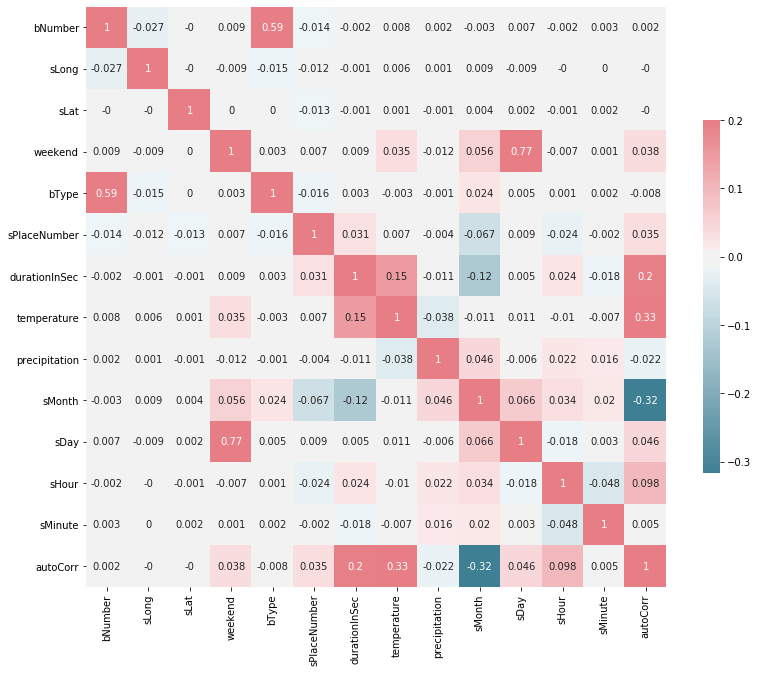

In [52]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(13,13))
sns.heatmap(corr, cmap=cmap, vmax=.2, center=0, annot=True,
            square=True, cbar_kws={"shrink": .5})

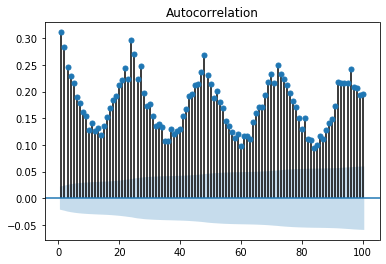

In [43]:
#correlation
plot_acf(dfGroups.fillna(allMean),unbiased=True,zero=False,lags=100)
plt.show()


In [16]:
dfPP = dfTrips.copy()
dfPP['sTime'] = dfPP['sTime'].astype('str')

for col in dfPP.columns:
    
    print(pps.score(dfPP,col,'durationInSec',))

{'x': 'bNumber', 'y': 'durationInSec', 'task': 'regression', 'ppscore': 0, 'metric': 'mean absolute error', 'baseline_score': 547.908, 'model_score': 613.4286196580504, 'model': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')}
{'x': 'sTime', 'y': 'durationInSec', 'task': 'regression', 'ppscore': 0, 'metric': 'mean absolute error', 'baseline_score': 547.908, 'model_score': 550.0896, 'model': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_s

Hour: 0
Hour: 1
Hour: 2
Hour: 3
Hour: 4
Hour: 5
Hour: 6
Hour: 7
Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20
Hour: 21
Hour: 22
Hour: 23


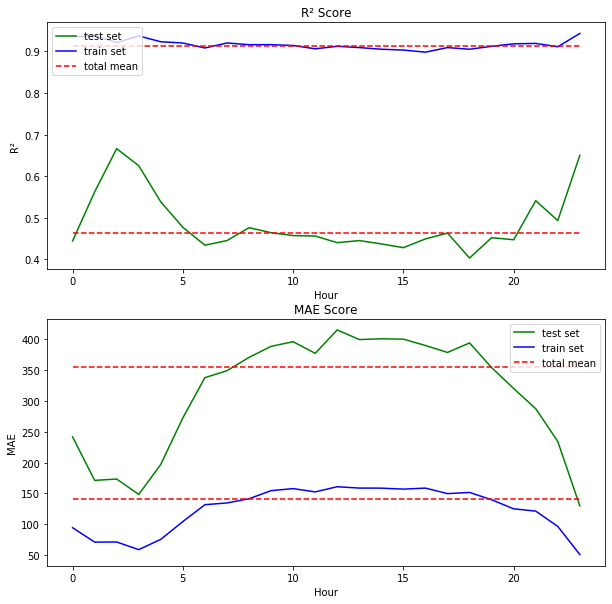

In [55]:
def flat_array(inputList):
    
    temparray = np.empty([1])
    
    for row in inputList:
        row = row.reshape(-1)
        temparray = np.concatenate((temparray,row),axis=0)

    return temparray
dfTrips.dropna(inplace=True)
dfTrips.drop(inplace=True, columns=['bNumber','sTime','sLong','sLat','precipitation','sMonth','sDay','bType'], errors='ignore')
dfPred = []
xScaler = []
yScaler = []
X = []
Y = []
r2_train = []
r2_test = []
mae_train = []
mae_test = []
regressor = []
reg_prediction_test = []
reg_y_train = []
reg_prediction_train =[]
reg_y_test = []
for hour in range(24):
    print('Hour: '+ str(hour))
    dfPred.append(dfTrips.loc[dfTrips['sHour'] == hour])
    #dfPred.append(dfTrips)
    dfPred[hour] = pd.concat([dfPred[hour], pd.get_dummies(dfPred[hour]['sPlaceNumber'],drop_first=True,dtype='int')],axis=1)
    Y.append(dfPred[hour]['durationInSec'].values)
    dfPred[hour].drop(inplace=True,columns=['durationInSec'],errors='ignore')
    X.append(dfPred[hour].values)
    
    
    x_test, x_train, y_test, y_train = train_test_split(X[hour],Y[hour], test_size=0.3)
    sscaler = StandardScaler()
    x_train = sscaler.fit_transform(x_train)
    x_test = sscaler.transform(x_test)
    xScaler.append(sscaler)
    sscaler2 = StandardScaler()
    
    y_train = sscaler2.fit_transform(y_train.reshape(-1,1))
    y_test = sscaler2.transform(y_test.reshape(-1,1))
    yScaler.append(sscaler2)
    
    #poly_reg = PolynomialFeatures(degree=4)
    #x_test = poly_reg.fit_transform(x_test)
    #x_train = poly_reg.fit_transform(x_train)
    reg = RandomForestRegressor(n_jobs=-1,n_estimators=100)
    #reg = LinearRegression(n_jobs=-1)
    #print(np.isnan(x_train,out=True))
    reg.fit(x_train,y_train)
    train_prediction = sscaler2.inverse_transform(reg.predict(x_train))
    test_prediction = sscaler2.inverse_transform(reg.predict(x_test))
    
    y_train = sscaler2.inverse_transform(y_train)
    y_test = sscaler2.inverse_transform(y_test)


    reg_prediction_train.append(train_prediction)
    reg_prediction_test.append(test_prediction)
    reg_y_train.append(y_train)
    reg_y_test.append(y_test)


    r2_train.append(np.round(r2_score(y_train,train_prediction),3))
    r2_test.append(np.round(r2_score(y_test,test_prediction),3))
    mae_train.append(np.round(mean_absolute_error(y_train,train_prediction),3))
    mae_test.append(np.round(mean_absolute_error(y_test,test_prediction),3))
    #print('R2 Train: ' ,np.round(reg.score(x_train,y_train),3))
    #print('R2 Test: ' , np.round(reg.score(x_test,y_test),3))
    #print('MAE Train: ', np.round(mean_absolute_error(sscaler2.inverse_transform(y_train),sscaler2.inverse_transform(reg.predict(x_train))),3))
    #print('MAE Test: ', np.round(mean_absolute_error(sscaler2.inverse_transform(y_test),sscaler2.inverse_transform(reg.predict(x_test))),3))


reg_y_test = flat_array(reg_y_test)
reg_y_train = flat_array(reg_y_train)
reg_prediction_train = flat_array(reg_prediction_train)
reg_prediction_test = flat_array(reg_prediction_test)


mean_r2_test = r2_score(reg_y_test, reg_prediction_test)
mean_r2_train = r2_score(reg_y_train, reg_prediction_train)
mean_mae_train = mean_absolute_error(reg_y_train, reg_prediction_train)
mean_mae_test = mean_absolute_error(reg_y_test, reg_prediction_test)

fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_size_inches(10, 10)
ax1.plot(range(24), r2_test, color='green', label='test set')
ax1.plot(range(24), r2_train, color='blue', label='train set')
ax1.plot([mean_r2_test]*24,'r--',label='total mean')
ax1.plot([mean_r2_train]*24,'r--')
ax1.set_title('R² Score')
ax1.legend(loc='upper left')
ax1.set(xlabel='Hour', ylabel='R²')
ax2.plot(range(24), mae_test, color='green', label='test set')
ax2.plot(range(24), mae_train, color='blue', label='train set')
ax2.plot([mean_mae_test]*24,'r--',label='total mean')
ax2.plot([mean_mae_train]*24,'r--')

ax2.set_title('MAE Score')
ax2.set(xlabel='Hour', ylabel='MAE')
ax2.legend(loc='upper right')


In [14]:
mean_mae_test

353.0421254535062

In [16]:
mean_mae_test

355.6212944400119

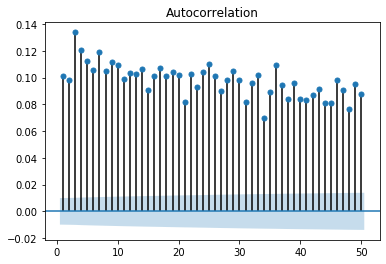

In [14]:
plot_acf(dfTrips.loc[dfTrips['sTime'].dt.hour == 15,['durationInSec']],lags=50,zero=False,unbiased=True)
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error 
from sklearn.linear_model import LinearRegression

def plotPerformance (featureList, maxPolyDegree, df, hour):
    
    df = df[df['sHour'] == hour]
    
    polynomialDegrees = [*range(1, maxPolyDegree + 1,1)]
    r2_test = []
    mae_test = []
    r2_train = []
    mae_train = []

    for polynomialDegree in polynomialDegrees:

        X = df[featureList].values
        Y = df[['duration']].values

        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

        poly_reg = PolynomialFeatures (degree = polynomialDegree)
        x_poly = poly_reg.fit_transform(x_train)

        model = LinearRegression(normalize = True, n_jobs=-1)
        model.fit(x_poly, y_train)

        y_pred_test = model.predict(poly_reg.fit_transform(x_test))
        y_pred_train = model.predict(poly_reg.fit_transform(x_train))
        r2_test.append(r2_score(y_test, y_pred_test))
        r2_train.append(r2_score(y_train, y_pred_train))
        mae_test.append(mean_absolute_error(y_test, y_pred_test))
        mae_train.append(mean_absolute_error(y_train, y_pred_train))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 5)
    ax1.plot([*range(1, maxPolyDegree + 1,1)], r2_test, color='green', label='test set')
    ax1.plot([*range(1, maxPolyDegree + 1,1)], r2_train, color='blue', label='train set')
    ax1.set_title('R² Score')
    ax1.legend(loc='upper left')
    ax1.set(xlabel='Polynomial Degree', ylabel='R²')
    ax2.plot([*range(1, maxPolyDegree + 1,1)], mae_test, color='green', label='test set')
    ax2.plot([*range(1, maxPolyDegree + 1,1)], mae_train, color='blue', label='train set')
    ax2.set_title('MAE Score')
    ax2.set(xlabel='Polynomial Degree', ylabel='MAE')
    ax2.legend(loc='upper right')

    return r2_test, r2_train, mae_test, mae_train

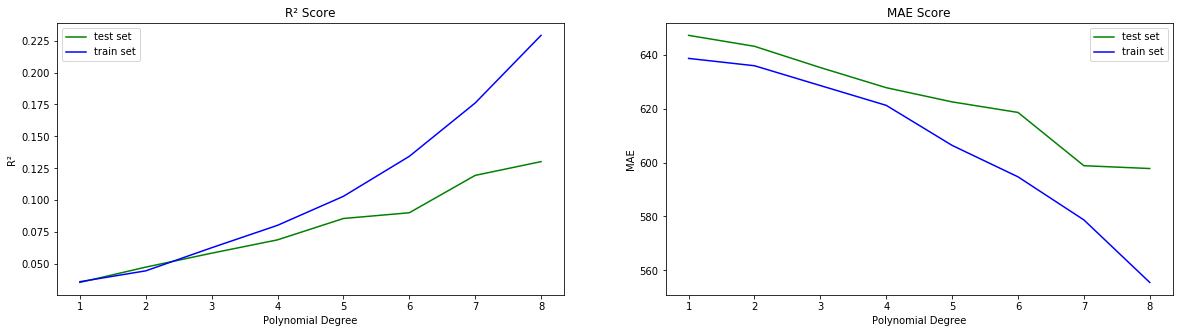

In [18]:
r2_test, r2_train, mae_test, mae_train = plotPerformance(featureList=['sMonth', 'sDay', 'temperature', 'sMinute', 'sPlaceNumber'], maxPolyDegree=8, df=dfTrips, hour=15)

In [3]:
dfTrips.head()

,bNumber,sTime,eTime,duration,sLong,sLat,eLong,eLat,weekend,bType,sPlaceNumber,ePlaceNumber,durationInSec
0,11169,2019-01-20 01:55:00,2019-01-20 02:06:00,00:11:00,8.763266,50.795224,8.770358,50.804522,True,15,5173.0,5159.0,660
2,11169,2019-01-20 11:58:00,2019-01-20 12:06:00,00:08:00,8.770358,50.804522,8.759248,50.804725,True,15,5159.0,5178.0,480
3,11169,2019-01-20 15:12:00,2019-01-20 15:27:00,00:15:00,8.759248,50.804725,8.774681,50.822927,True,15,5178.0,5150.0,900
4,11169,2019-01-20 15:39:00,2019-01-20 15:42:00,00:03:00,8.774681,50.822927,8.774681,50.822927,True,15,5150.0,5150.0,180
5,11270,2019-01-20 00:25:00,2019-01-20 00:37:00,00:12:00,8.775948,50.813203,8.775948,50.813203,True,15,5156.0,5156.0,720


In [20]:
# Test package
!pip install -e ..
dfRaw = nextbike.io.read_file()
df = nextbike.io.createTrips(dfRaw)



Obtaining file:///C:/Users/loren/Documents/GitHub/PDS_Project
  Attempting uninstall: PDS-Project
    Found existing installation: PDS-Project 0.0.1.dev13
    Uninstalling PDS-Project-0.0.1.dev13:
      Successfully uninstalled PDS-Project-0.0.1.dev13
  Running setup.py develop for PDS-Project


In [21]:
dfTrips = df.copy()

In [18]:

clean_outliner = False
train_test = True
return_error = True
#dfTrips = df.copy()
if clean_outliner:
    dfTrips = nextbike.io.input.drop_outliners(dfTrips)
    
# Import weather data.
dfWeather = nextbike.io.getWeatherData()
dfWeatherMinutes = pd.DataFrame({'date': pd.date_range('2019-01-01', '2020-01-01', freq='min', closed='left')})
dfWeatherMinutes = dfWeatherMinutes.set_index('date')
dfWeatherMinutes = dfWeatherMinutes.join(dfWeather)
dfWeatherMinutes = dfWeatherMinutes.fillna(axis='index', method='ffill')

# Join trips and weather data. Prepare trip data.
dfTrips = dfTrips.join(dfWeatherMinutes, how='left', on='sTime')
dfTrips = dfTrips.drop(columns=['eTime', 'eLong', 'eLat', 'ePlaceNumber'],errors='ignore')
dfTrips['sMonth'] = dfTrips['sTime'].dt.month
dfTrips['sDay'] = dfTrips['sTime'].dt.weekday
dfTrips['sHour'] = dfTrips['sTime'].dt.hour
dfTrips['sMinute'] = dfTrips['sTime'].dt.minute
dfTrips['durationInSec'] = dfTrips['duration'].dt.total_seconds()
dfTrips.drop(inplace=True, columns=['bNumber','sLong','sLat','precipitation','sMonth','sDay','bType','duration'], errors='ignore')

# Include autocorrelation. Mean duration of the hour before the trip. 
# If no mean is available the mean of the total dataset is used.
dfGroups = dfTrips.resample('h',on='sTime')['durationInSec'].mean().shift(1)
allMean = dfTrips['durationInSec'].mean()
dfTrips['autoCorr'] = allMean
for label,content in dfGroups.items():
    dfTrips.loc[dfTrips['sTime'].dt.floor('H') == label,['autoCorr']] = content
dfTrips['autoCorr'].fillna(allMean,inplace=True)

# Prediction

dfPred = pd.concat([dfTrips, pd.get_dummies(dfTrips['sPlaceNumber'],drop_first=True,dtype='int')],axis=1)
print(dfPred.head(1))
dfPred.drop(inplace=True,columns=['sTime'],errors='ignore')
Y = dfPred['durationInSec'].values
dfPred.drop(inplace=True,columns=['durationInSec'],errors='ignore')
X = dfPred.values
if train_test:
    x_test, x_train, y_test, y_train = train_test_split(X,Y, test_size=0.3)
else:
    x_test, x_train, y_test, y_train = train_test_split(X,Y, test_size=0.01)

sscaler = StandardScaler()
x_train = sscaler.fit_transform(x_train)
x_test = sscaler.transform(x_test)
sscaler2 = StandardScaler()
y_train = sscaler2.fit_transform(y_train.reshape(-1,1))
y_test = sscaler2.transform(y_test.reshape(-1,1))

model = RandomForestRegressor(n_jobs=-1,n_estimators=100)

model.fit(x_train,y_train)
train_prediction = sscaler2.inverse_transform(model.predict(x_train))
test_prediction = sscaler2.inverse_transform(model.predict(x_test))

y_train = sscaler2.inverse_transform(y_train)
y_test = sscaler2.inverse_transform(y_test)

r2_train = np.round(r2_score(y_train,train_prediction),3)
r2_test = np.round(r2_score(y_test,test_prediction),3)
mae_train = np.round(mean_absolute_error(y_train,train_prediction),3) 
mae_test = np.round(mean_absolute_error(y_test,test_prediction),3)
io.save_model(model)
#return model, r2_train, r2_test, mae_train, mae_test

#model, *_ = nextbike.prediction.train_model(dfTrips, clean_outliner=False)

ValueError: columns overlap but no suffix specified: Index(['temperature'], dtype='object')

In [19]:
dfTrips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630969 entries, 0 to 630968
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   sTime          630969 non-null  datetime64[ns]
 1   weekend        630969 non-null  bool          
 2   sPlaceNumber   630927 non-null  float64       
 3   temperature    630969 non-null  float64       
 4   sHour          630969 non-null  int64         
 5   sMinute        630969 non-null  int64         
 6   durationInSec  630969 non-null  float64       
 7   autoCorr       630969 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(4), int64(2)
memory usage: 34.3 MB
